In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import random as rnd
import math
import gzip
import sys
import os
import time
from collections import defaultdict


DIRAC NOTATION - Vectors

1. Vector will be 2^n size where n is the number of wires that we have
2. convert a np array of tuples with amplitude, bit string into pretty way first

In [2]:
myState=[
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01') ,
  (-np.sqrt(0.5), '11' )
]

def PrettyPrintBinary(myState):
	finalPrettyString = "("
	for i, row in enumerate(myState):
		numericalVal = row[0]
		binString = row[1]
		numericalStr = f"{numericalVal:.12f}"
		if i > 0:
			finalPrettyString += " +"
		finalPrettyString += f" {numericalStr}  |{binString}>"
		
	return finalPrettyString

def PrettyPrintInteger(myState):
	finalPrettyString = "("
	for i, row in enumerate(myState):
		numericalVal = row[0]
		binString = row[1]
		numericalStr = f"{numericalVal:.12f}"
		if i > 0:
			finalPrettyString += " +"
		evaluatedBinString = StringBinaryToNum(binString)
		finalPrettyString += f" {numericalStr}  |{evaluatedBinString}>"
	return finalPrettyString

def StringBinaryToNum(binString):
	number = 0
	for i in range(len(binString)):
		number += int(binString[i]) * (2**(len(binString) - 1 - i))
	return number

# GRADING 1 - DIRAC NOTATION
myState2 = [
  (np.sqrt(0.1)*1.j, '101'),
  (np.sqrt(0.5), '000'),
  (-np.sqrt(0.4), '010')
]
print(PrettyPrintBinary(myState2))
print(PrettyPrintInteger(myState2))

def DiracToVec(myState):
	quibitCount = len(myState[0][1])
	arr = [0] * 2**(quibitCount)
	for amplitude, binString in myState:
		idx = StringBinaryToNum(binString)
		arr[idx] = amplitude
	return arr

def VecToDirac(arr):
	myState = []
	qubitCount = int(math.log2(len(arr)))	
	for i, amplitude in enumerate(arr):
		if amplitude != 0:
			binaryStr = format(i, f'0{qubitCount}b')
			myState.append((amplitude, binaryStr))
	return myState

# GRADING 2 - Dirac Notation
print(DiracToVec(myState2))
print(VecToDirac(DiracToVec(myState2)))


# MY OWN TESTING - IGNORE FOR GRADING
# PrettyPrintBinary from state to prettyPrint - Dirac Notation Page
# print(PrettyPrintBinary(myState))
# # Testing converting binarystring to int number StringBinaryToNum
# print(StringBinaryToNum('00'))
# # PrettyPrintInteger from state to prettyPrint with actual num not binary - Dirac Notation Page
# print(PrettyPrintInteger(myState))

( 0.000000000000+0.316227766017j  |101> + 0.707106781187  |000> + -0.632455532034  |010>
( 0.000000000000+0.316227766017j  |5> + 0.707106781187  |0> + -0.632455532034  |2>
[0.7071067811865476, 0, -0.6324555320336759, 0, 0, 0.31622776601683794j, 0, 0]
[(0.7071067811865476, '000'), (-0.6324555320336759, '010'), (0.31622776601683794j, '101')]


SIMULATOR S

In [3]:
'''
	Hadamard - (Page: Simulator S)
		- H(wire, inputState)
			* wire = index to look at of the BinaryString, can be 0 or 1, then just apply the rules to the (amplitude, strin)
			* do for every state in the inputState
'''
# Suppose this is my current circuit, 2 wires, 0th wire has the Hadamard(MSB), so my H function needs to go through the entire basicState1, talk to the
# wire Index of the binString and apply the rule to the magnitude and to that index and then append 2 tuples
basicState1 = [
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01'),
  (-np.sqrt(0.5), '11')
]
def H(wire, inputState):
	outputState = []
	for state in inputState:
		binaryString = state[1]
		leadingPart = binaryString[:wire]
		trailingPart = binaryString[wire + 1:]

		if state[1][wire] == '0':
			tuple1 = (state[0]*(1/np.sqrt(2)), leadingPart + '0' + trailingPart)
			tuple2 = (state[0]*(1/np.sqrt(2)), leadingPart + '1' + trailingPart)
			outputState.append(tuple1)
			outputState.append(tuple2)
		elif state[1][wire] == '1':
			tuple1 = (state[0]*(1/np.sqrt(2)), leadingPart + '0' + trailingPart)
			tuple2 = (state[0]*(-1/np.sqrt(2)), leadingPart + '1' + trailingPart)
			outputState.append(tuple1)
			outputState.append(tuple2)

	return outputState

print(H(0, basicState1))
print(H(1, basicState1))

'''
	Phase Gate - (Page: Simulator S)
		- Phase(wire, theta, inputState)
			* wire, inputState works exactly like hadamard, but the theta is is just applied to the amplitude, following the rule, the binaryString
			is not being changed just the overall amplitude
'''
basicState1 = [
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01'),
  (-np.sqrt(0.5), '11')
]
def Phase(wire, theta, inputState):
	outputState = []
	for state in inputState:
		if state[1][wire] == '0':
			outputState.append(state)
		elif state[1][wire] == '1':
			outputState.append((state[0] * np.exp(1j * theta), state[1]))
	
	return outputState

print(Phase(0, np.pi / 2, basicState1))
print(Phase(1, np.pi / 2, basicState1))

'''
	CNOT Gate - (Page: Simulator S)
		- CNOT(controlWire, notWire, inputState)
			* input state works like hadamard, but the logic is look at binString of the inputState, if binString[controlWire] == '1' then flip
			the value of binString[notWire]
'''
basicState1 = [
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01'),
  (-np.sqrt(0.5), '11')
]

def CNOT(controlWire, notWire, inputState):
	charMap = {'1' : '0', '0' : '1'}
	outputState = []
	for amplitude, binString in inputState:
		if binString[controlWire] == '1':
			newBinString = binString[:notWire] + charMap[binString[notWire]] + binString[notWire + 1:]
			outputState.append((amplitude, newBinString))
		else:
			outputState.append((amplitude, binString))
	return outputState

print(CNOT(0, 1, basicState1))

'''
	Duplicate States - (Page: Simulator S)
		- AddDuplicate(outputState)
		* given some outputState if there are states with the same BinString add them, use a map
		* if u come across a tuple with a 0 amplitude just remove it from the list
'''
def AddDuplicates(outputState):
	myMap = {}
	updatedState = []
	for amplitude, binString in outputState:
		if amplitude == 0:
			continue

		if binString in myMap:
			myMap[binString] += amplitude
		else:
			myMap[binString] = amplitude
	
	for key, value in myMap.items():
		updatedState.append((value, key))

	return updatedState

# TESTING WITH THE EXAMPLE GIVEN
myState=[
  (-np.sqrt(0.125), '11'),
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01') ,
  (-np.sqrt(0.125), '11' )
]
print(AddDuplicates(myState))

[(0.22360679774997896, '00'), (0.22360679774997896, '10'), (0.4472135954999579, '01'), (0.4472135954999579, '11'), (-0.5, '01'), (0.5, '11')]
[(0.22360679774997896, '00'), (0.22360679774997896, '01'), (0.4472135954999579, '00'), (-0.4472135954999579, '01'), (-0.5, '10'), (0.5, '11')]
[(0.31622776601683794, '00'), (0.6324555320336759, '01'), ((-4.329780281177467e-17-0.7071067811865476j), '11')]
[(0.31622776601683794, '00'), ((3.8726732145403873e-17+0.6324555320336759j), '01'), ((-4.329780281177467e-17-0.7071067811865476j), '11')]
[(0.31622776601683794, '00'), (0.6324555320336759, '01'), (-0.7071067811865476, '10')]
[(-0.7071067811865476, '11'), (0.31622776601683794, '00'), (0.6324555320336759, '01')]


In [4]:
'''
	Putting it Together - (Page 2: Simulator S)
		- myInput is a list of lists, just iterate through the list calling the right functions based on
          the contents of each sublist
'''
def ReadInputString(myInput_lines):
    myInput=[]
    myInput_lines=myInput_lines.split('\n')
    myInput_lines = [ i for i in myInput_lines if i!='']
    numberOfWires=int(myInput_lines[0])
    for line in myInput_lines[1:]:
        myInput.append(line.split())
    return (numberOfWires,myInput)

def SimulatorS(numberOfWires, myInput):
    initialState = [(1, '0'*numberOfWires)]
    currentState = initialState
    for sublist in myInput:
        func = sublist[0]
        if func == 'H':
            wire = int(sublist[1])
            currentState = H(wire, currentState)
            currentState = AddDuplicates(currentState)
        elif func == 'P':
            wire = int(sublist[1])
            theta = float(sublist[2])
            currentState = Phase(wire, theta, currentState)
        if func == 'CNOT':
            controlWire = int(sublist[1])
            notWire = int(sublist[2])
            currentState = CNOT(controlWire, notWire, currentState)
    # Convert VecToDirac notation
    return currentState

# numberOfWires,myInput=ReadInputString(open('test.circuit').read())
# print(SimulatorS(numberOfWires, myInput), " --> This matches the output on the QC Simulators Initial Base Page.")

# numberOfWires,myInput=ReadInputString(open('example.circuit').read())
# print(SimulatorS(numberOfWires, myInput), " --> This matches the output on the Simulator S Page.")

# GRADING MY CIRCUIT
numberOfWires,myInput=ReadInputString(open('rand.circuit').read())
print(SimulatorS(numberOfWires, myInput))

[((0.14565796004368053+0.11348294333323078j), '00000'), ((-0.00017826157500451523+0.08005459383129263j), '00010'), ((0.001474690001990242-0.036459032126468296j), '10000'), ((-0.08205100536822742+0.015513990179495578j), '10010'), ((0.043097550946832784-0.12184596055817087j), '00001'), ((0.050356298688186536-0.007282489799443265j), '00011'), ((-0.012673925486559922+0.005514371048822539j), '10001'), ((0.01601173967169032+0.022594139337382343j), '10011'), ((0.0723267255921635-0.022619270303906355j), '00100'), ((0.05394795241192351+0.008954381028197912j), '00110'), ((-0.17165615534648057+0.3669221138055029j), '10100'), ((-0.14693154505266529-0.0436146109063518j), '10110'), ((-0.03444784817538656-0.04222821092998368j), '00101'), ((0.0017934458673293727-0.026754015134267235j), '00111'), ((0.27747135781393106+0.042329407228946035j), '10101'), ((0.007401893528164782+0.10788583514551453j), '10111'), ((0.13464628848368848-0.1256031965657913j), '01000'), ((0.010652323173449786+0.07094564243091285j

SIMULATOR Ma

In [5]:
'''
	TensorMe
		- Takes a Matrix list: [I, I, H, I] and then returns the tensor product of the whole thing
'''
def TensorMe(matrixList):
	outputMatrix = matrixList[0]
	for mat in matrixList[1:]:
		outputMatrix = np.kron(outputMatrix, mat)
	return outputMatrix

'''
	Hadamard Matrix Way - (Simulator M-(Abcd) Page)
		- Depending on number of wires check which has the H gate then then tensor product with I's depending on the other wires
'''
def HadamardArray(i, k):
	H_matrix = 1/np.sqrt(2) * np.array([[1, 1],[1, -1]])
	I_matrix = np.array([[1, 0], [0, 1]])
	matrixList = []
	for wire in range(k):
		if wire == i:
			matrixList.append(H_matrix)
		else:
			matrixList.append(I_matrix)
	return TensorMe(matrixList)

def PhaseArray(i, k, theta):
	P_matrix = np.array([[1, 0], [0, np.exp(1j * theta)]])
	I_matrix = np.array([[1, 0], [0, 1]])
	matrixList = []
	for wire in range(k):
		if wire == i:
			matrixList.append(P_matrix)
		else:
			matrixList.append(I_matrix)
	return TensorMe(matrixList)

'''
	CNotArray(controlWire, notWire, k)
		- so we have to follow the same idea here where we do I x I..... x Cnot x .... whatever blah
		- but Cnot is a 4 x 4 matrix because it spans over two wires, and the order matters
		- if control is above notWire meaning control < notWire then we have a standard permutation matrix
		- but if control is below notWire meaning control > notWire then we have to flip the 2^1 and 2^2 rows here.
'''
def CNotArray(controlWire, notWire, k):
	# control is above the notWire = regular Cnot_matrix
	Cnot_up = np.array([[1, 0, 0, 0], 
					    [0, 1, 0, 0], 
						[0, 0, 0, 1], 
						[0, 0, 1, 0]])
    # control is below the not wire = upside down Cnot_matrix
	Cnot_down = np.array([[1, 0, 0, 0], 
					      [0, 0, 0, 1], 
						  [0, 0, 1, 0], 
						  [0, 1, 0, 0]])
	I_matrix = np.array([[1, 0], [0, 1]])
	
	if controlWire < notWire:
		Cnot = Cnot_up
	else:
		Cnot = Cnot_down 
	
	matrixList = []
	for wire in range(k):
		if wire == controlWire:
			matrixList.append(Cnot)
		elif wire == notWire:
			continue
		else:
			matrixList.append(I_matrix)
	return TensorMe(matrixList)

# TESTING CNOTArray
initial_state = np.zeros(2**4)
initial_state[2] = 1 # 0 0 1 0
print(initial_state)
myOutputState = CNotArray(2, 3, 4) @ initial_state
print(myOutputState, " - which makes sense because |0010> -> |0011> which means in the vector of size 16 index 3 = 1 CHECK!!!")

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  - which makes sense because |0010> -> |0011> which means in the vector of size 16 index 3 = 1 CHECK!!!


In [6]:
def ReadInputString(myInput_lines):
    myInput=[]
    myInput_lines=myInput_lines.split('\n')
    myInput_lines = [ i for i in myInput_lines if i!='']
    numberOfWires=int(myInput_lines[0])
    for line in myInput_lines[1:]:
        myInput.append(line.split())
    return (numberOfWires,myInput)

def SimulatorMa(numberOfWires, myInput):
    gate_matrices = []
    for sublist in myInput:
        func = sublist[0]
        if func == 'H':
            wire = int(sublist[1])
            gate_matrices.append(HadamardArray(wire, numberOfWires))
        elif func == 'P':
            wire = int(sublist[1])
            theta = float(sublist[2])
            gate_matrices.append(PhaseArray(wire, numberOfWires, theta))
        if func == 'CNOT':
            controlWire = int(sublist[1])
            notWire = int(sublist[2])
            gate_matrices.append(CNotArray(controlWire, notWire, numberOfWires))

    outputMatrix = gate_matrices[-1]
    for matrix in reversed(gate_matrices[:-1]):
        outputMatrix = outputMatrix @ matrix
    
    return outputMatrix


# Example usage
# numberOfWires, myInput = ReadInputString(open('combining_gates.circuit').read())
# print(numberOfWires, myInput)
# print(SimulatorMa(numberOfWires, myInput))

# numberOfWires,myInput=ReadInputString(open('test.circuit').read())
# print(SimulatorMa(numberOfWires, myInput))

# numberOfWires,myInput=ReadInputString(open('example.circuit').read())
# print(SimulatorMa(numberOfWires, myInput))

# GRADING MY CIRCUIT
numberOfWires,myInput=ReadInputString(open('rand.circuit').read())
V = np.zeros(2**numberOfWires)
V[0] = 1  # This sets the state to |0...0⟩
unitary_matrix = SimulatorMa(numberOfWires, myInput)
print(len(unitary_matrix), len(unitary_matrix[0]))
print(unitary_matrix @ V)

32 32
[ 1.45657960e-01+0.11348294j  4.30975509e-02-0.12184596j
 -1.78261575e-04+0.08005459j  5.03562987e-02-0.00728249j
  7.23267256e-02-0.02261927j -3.44478482e-02-0.04222821j
  5.39479524e-02+0.00895438j  1.79344587e-03-0.02675402j
  1.34646288e-01-0.1256032j  -1.04099721e-01-0.06762381j
  1.06523232e-02+0.07094564j  3.15367896e-02-0.0353778j
  7.92047445e-03+0.29789851j  1.96081268e-01-0.05835345j
 -1.13065301e-01-0.02284308j  2.56706534e-02+0.07563945j
  1.47469000e-03-0.03645903j -1.26739255e-02+0.00551437j
 -8.20510054e-02+0.01551399j  1.60117397e-02+0.02259414j
 -1.71656155e-01+0.36692211j  2.77471358e-01+0.04232941j
 -1.46931545e-01-0.04361461j  7.40189353e-03+0.10788584j
 -4.42679640e-01-0.08917052j  3.43250738e-02+0.31797145j
 -5.47885758e-02-0.21473167j -1.20985483e-01+0.0654484j
 -1.81443370e-01-0.07802774j -5.85014757e-03+0.12703337j
 -5.78106522e-02+0.01012336j -1.18130812e-02+0.02004417j]


SIMULATOR Mb

In [7]:
'''
	SimulatorMb
		- I do not need to make any changes to any of the other functions in Simulator Ma, only difference is how I am calculating my
        unitary matrix so rather than how in Ma I created an array and just multiplied the matrixes in the reverse order, this time
        in Mb
			- C @ (B @ (A @ V))
'''
def SimulatorMb(numberOfWires, myInput, initialState):
    currentState = initialState
    for sublist in myInput:
        func = sublist[0]
        if func == 'H':
            wire = int(sublist[1])
            currentState = HadamardArray(wire, numberOfWires) @ currentState
        elif func == 'P':
            wire = int(sublist[1])
            theta = float(sublist[2])
            currentState = PhaseArray(wire, numberOfWires, theta) @ currentState
        elif func == 'CNOT':
            controlWire = int(sublist[1])
            notWire = int(sublist[2])
            currentState = CNotArray(controlWire, notWire, numberOfWires) @ currentState
    return currentState

###########     TEST CASES      ####################
numberOfWires, myInput = ReadInputString(open('combining_gates.circuit').read())
Vin = np.zeros(2**numberOfWires)
Vin[0] = 1
Vout = SimulatorMb(numberOfWires, myInput, Vin)

numberOfWires, myInput = ReadInputString(open('test.circuit').read())
Vin = np.zeros(2**numberOfWires)
Vin[0] = 1
Vout = SimulatorMb(numberOfWires, myInput, Vin)

numberOfWires, myInput = ReadInputString(open('example.circuit').read())
Vin = np.zeros(2**numberOfWires)
Vin[0] = 1
Vout = SimulatorMb(numberOfWires, myInput, Vin)

numberOfWires, myInput = ReadInputString(open('rand.circuit').read())
Vin = np.zeros(2**numberOfWires)
Vin[0] = 1
Vout = SimulatorMb(numberOfWires, myInput, Vin)
print(Vout)

[ 1.45657960e-01+0.11348294j  4.30975509e-02-0.12184596j
 -1.78261575e-04+0.08005459j  5.03562987e-02-0.00728249j
  7.23267256e-02-0.02261927j -3.44478482e-02-0.04222821j
  5.39479524e-02+0.00895438j  1.79344587e-03-0.02675402j
  1.34646288e-01-0.1256032j  -1.04099721e-01-0.06762381j
  1.06523232e-02+0.07094564j  3.15367896e-02-0.0353778j
  7.92047445e-03+0.29789851j  1.96081268e-01-0.05835345j
 -1.13065301e-01-0.02284308j  2.56706534e-02+0.07563945j
  1.47469000e-03-0.03645903j -1.26739255e-02+0.00551437j
 -8.20510054e-02+0.01551399j  1.60117397e-02+0.02259414j
 -1.71656155e-01+0.36692211j  2.77471358e-01+0.04232941j
 -1.46931545e-01-0.04361461j  7.40189353e-03+0.10788584j
 -4.42679640e-01-0.08917052j  3.43250738e-02+0.31797145j
 -5.47885758e-02-0.21473167j -1.20985483e-01+0.0654484j
 -1.81443370e-01-0.07802774j -5.85014757e-03+0.12703337j
 -5.78106522e-02+0.01012336j -1.18130812e-02+0.02004417j]


GRAPH OF COMPUTATIONAL COMPLEXITY

In [8]:
'''
	Need to generate random circuits and then run those circuits on the 3 simulators timings how long it takes
	the circuits to run for each simulator vs the number of quibits that the circuits have

	createCircuit - make a random circuit for wire len, and circuitlen = number of gates
	AddToFile - takes that circuit I just made and writes it to a file
	GenerateRandomCircuits - calls the create and Add functions that creates me x circuits that I need
'''
def createCircuit(quibitCount, circuitLen):
	gates = ['H', 'P', 'CNOT']
	myCircuit = []
	myCircuit.append([quibitCount])
	for i in range(circuitLen):
		currGate = rnd.choice(gates)
		if currGate == 'H':
			wire = rnd.randint(0, quibitCount-1)
			myCircuit.append([currGate, wire])
		elif currGate == 'P':
			wire = rnd.randint(0, quibitCount-1)
			theta = rnd.uniform(0, 2 * 3.14159)  # Random angle for Phase gate
			myCircuit.append([currGate, wire, theta])
		elif currGate == 'CNOT':
			controlWire = rnd.randint(0, quibitCount-2)
			notWire = controlWire + 1
			myCircuit.append([currGate, controlWire, notWire])
	
	return myCircuit

def AddToFile(myCircuit, file_name):
	with open(file_name, mode='a') as file:
		for sublist in myCircuit:
			line = " ".join(str(item) for item in sublist)
			file.write(line + "\n")
		file.write("\n")

def GenerateRandomCircuits():
	file_name = "myRandomCircuits.circuit"
	if os.path.exists(file_name):
		os.remove(file_name)
	circuitLen = 4
	for quibitCount in range(5, 16):
		AddToFile(createCircuit(quibitCount, circuitLen), file_name)
		
GenerateRandomCircuits()


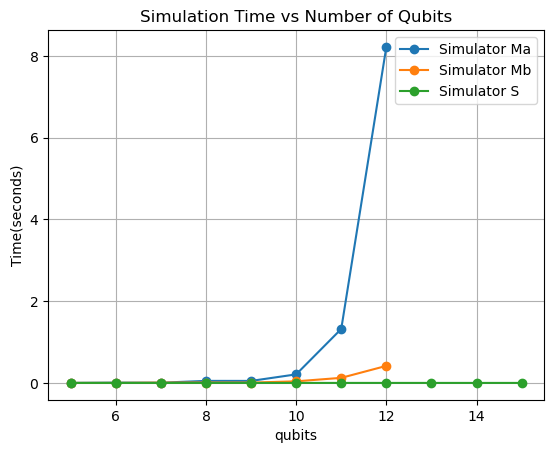

In [17]:
def ReadCircuitsFromFile(file_name):
    with open(file_name, 'r') as file:
        file_contents = file.read().strip()
    circuit_strings = file_contents.split('\n\n')
    all_circuits = []
    for circuit_string in circuit_strings:
        numberOfWires, myInput = ReadInputString(circuit_string)
        all_circuits.append((numberOfWires, myInput))
    return all_circuits

allSimulators = {
                    'Simulator Ma': SimulatorMa,
                    'Simulator Mb': SimulatorMb,
                    'Simulator S': SimulatorS
                }

def time_simulations(allSimulators):
    allCircuits = ReadCircuitsFromFile("myRandomCircuits.circuit")
    
    simulatorTimeMap = {}
    for simulator in allSimulators:
        simulatorTimeMap[simulator] = []
    quibitsList = []
    
    for i, circuit in enumerate(allCircuits):
        quibitCount, myInput = circuit
        quibitsList.append(quibitCount)
        # print(quibitCount, myInput)
        for name, simulator in allSimulators.items():
            # Define the range for each simulator
            if name == 'Simulator Ma' and quibitCount > 12:
                continue
            if name == 'Simulator Mb' and quibitCount > 12:
                continue
            if name == 'Simulator S' and quibitCount > 20:
                continue
            start = time.time()
            if simulator == SimulatorMb:
                Vin = np.zeros(2**quibitCount)
                Vin[0] = 1
                output = simulator(quibitCount, myInput, Vin)
            elif simulator == SimulatorS:
                output = simulator(quibitCount, myInput, False)
            else:
                output = simulator(quibitCount, myInput)
            end = time.time()
            simulatorTimeMap[name].append(end - start)
    for name, timings in simulatorTimeMap.items():
        plt.plot(quibitsList[:len(timings)], timings, marker='o', label=name)
    plt.xlabel('qubits')
    plt.ylabel('Time(seconds)')
    plt.title('Simulation Time vs Number of Qubits')
    plt.legend()
    plt.grid(True)
    plt.show()
        

time_simulations(allSimulators)

MEASURING AND INPUT(only udpates for SimulatorS so far)

In [22]:
'''
    1. Update SimulatorS so that it can return the measurement which the tuple with the best probability
    2. Update SimulatorS so that the initialState is updated as well
        right now I am providing an initial state but what if we want to give a new state to be read in.
        2 ways: INITSTATE FILE myInputState.txt, INITSTATE BASIS |????>
'''
# freqMap = defaultdict(int)

def ReadInputString(myInput_lines):
    myInput=[]
    myInput_lines=myInput_lines.split('\n')
    myInput_lines = [ i for i in myInput_lines if i!='']
    splitFirstList = myInput_lines[0].split()
    if(len(splitFirstList) > 1): # we are looking at the INITSTATE BASIS |....>
        numberOfWires = None
        myInput.append(splitFirstList)
    else:
        numberOfWires=int(myInput_lines[0])
    for line in myInput_lines[1:]:
        myInput.append(line.split())
    return (numberOfWires,myInput)

def generateInputStateFromFile(numberOfWires, file_path):
    initial_state = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for index, line in enumerate(lines):
        real, imaginary = line.split()
        real = float(real)
        imaginary = float(imaginary)
        amplitude = math.sqrt(real**2 + imaginary**2)
        binString = format(index, f'0{numberOfWires}b')
        initial_state.append((amplitude, binString))
    return initial_state

def findInitialState(myInput, numberOfWires):
    initial_state = []
    if myInput[0][0] == "INITSTATE":
        if myInput[0][1] == "FILE":
            initial_state = generateInputStateFromFile(numberOfWires, myInput[0][2])
        elif myInput[0][1] == "BASIS":
            startIndex = myInput[0][2].find('|') + 1
            endIndex = myInput[0][2].find('>')
            binString = myInput[0][2][startIndex:endIndex]
            initial_state.append((1, binString))
    else:
        initial_state.append((1, '0'*numberOfWires))
    return initial_state

def Measure(currentState, plot):
    freqMap = defaultdict(int)
    for i in range(1000):
        currStateProb = []
        weights = []
        for amplitude, bitString in currentState:  
            currStateProb.append((abs(amplitude)**2, bitString))
            weights.append(abs(amplitude)**2)
        measured_tuple = rnd.choices(currStateProb, weights=weights, k=1)[0]
        freqMap[measured_tuple] += 1

    if plot == True:
        labels = []
        for _, bitString in freqMap.keys():
            labels.append(int(bitString, 2))
        values = list(freqMap.values())
        plt.bar(labels, values)
        plt.xlabel('Measured Bit Strings')
        plt.ylabel('Frequency')
        plt.title('Frequency of Measured Bit Strings')
        plt.show()

        return max(freqMap, key=freqMap.get), freqMap

    max_measured_tuple = max(freqMap, key=freqMap.get)
    return max_measured_tuple    

def checkMeasurement(currentState):
    currStateProb = []
    weights = []
    currProbMax = -1
    maxBitString = ''
    for amplitude, bitString in currentState:
        if currProbMax < abs(amplitude)**2: 
            currProbMax = abs(amplitude)**2
            maxBitString = bitString
        currStateProb.append((abs(amplitude)**2, bitString))
        weights.append(abs(amplitude)**2)
    print(f"This should be the one that gets picked: ", (currProbMax, maxBitString))

def SimulatorS(numberOfWires, myInput, plot):
    # First check the input and see do we have the INITSTATE part or if we are using something default
    initialState = findInitialState(myInput, numberOfWires)
    currentState = initialState
    for sublist in myInput:
        func = sublist[0]
        if func == 'H':
            wire = int(sublist[1])
            currentState = H(wire, currentState)
            currentState = AddDuplicates(currentState) 
        elif func == 'P':
            wire = int(sublist[1])
            theta = float(sublist[2])
            currentState = Phase(wire, theta, currentState)
        elif func == 'CNOT':
            controlWire = int(sublist[1])
            notWire = int(sublist[2])
            currentState = CNOT(controlWire, notWire, currentState)
        elif func == 'MEASURE':
            # checkMeasurement(currentState)
            return Measure(currentState, plot)
    return currentState

numberOfWires,myInput=ReadInputString(open('input.circuit').read())
print(SimulatorS(numberOfWires, myInput, False))

numberOfWires,myInput=ReadInputString(open('measure.circuit').read())
# print(numberOfWires, myInput)
print(SimulatorS(numberOfWires, myInput, False))


[((0.042054272388587416-0.0009857947428106584j), '00000'), ((-0.19691318297843047+0.18126883927682202j), '00010'), ((0.060850760267472825+0.12658994155700343j), '10000'), ((0.24753181927345763+0.17665323266692678j), '10010'), ((-0.16424461403796833-0.0459396118981423j), '00001'), ((-0.13126768288075377-0.007460502258613139j), '00011'), ((-0.17203263022671456-0.09205456718337676j), '10001'), ((0.2489589433459995-0.13192708989442498j), '10011'), ((-0.055803942454559496+0.11990552314630311j), '00100'), ((0.04068521034284443-0.05618084495261581j), '00110'), ((0.02634007542531308+0.040729293739378586j), '10100'), ((0.09012895324049722+0.1769766090813376j), '10110'), ((0.0567943631071256-0.0918388421209902j), '00101'), ((0.1181916537665825-0.01135947751872482j), '00111'), ((-0.20539298472862563+0.030978428874940973j), '10101'), ((-0.0251463563296688+0.061002761231395364j), '10111'), ((0.0864474459247335-0.19680311882500734j), '01000'), ((-0.1041037583898305+0.019870036868240324j), '01010'), 

NON-ATOMIC GATES

In [11]:
'''
	All the Non atomic gates here, need to still implement long range CNOT
'''
def notGate(targetWire): # H P H
	myInput = []
	myInput.append((['H', targetWire]))
	myInput.append((['P', targetWire, np.pi]))
	myInput.append((['H', targetWire]))
	return myInput

def rzGate(targetWire, theta): # NOT P NOT P
	myInput = []
	firstNot = notGate(targetWire)
	myInput += firstNot
	myInput.append((['P', targetWire, -float(theta) / 2]))
	firstNot = notGate(targetWire)
	myInput += firstNot
	myInput.append((['P', targetWire, float(theta) / 2]))
	return myInput

def crzGate(controlWire, notWire, theta):
	myInput = []
	myInput.append((['CNOT', controlWire, notWire]))
	myInput.append((['P', notWire, -float(theta) / 2]))
	myInput.append((['CNOT', controlWire, notWire]))
	myInput.append((['P', notWire, float(theta) / 2]))
	return myInput

def cpGate(controlWire, notWire, theta):
	myInput = []
	myInput += crzGate(controlWire, notWire, theta)
	myInput.append((['P', controlWire, float(theta) / 2]))
	return myInput

 # CNOT CNOT CNOT: if the first wire has 1 state then copy the 1 to the 2nd wire, then if 2nd wire is 1 
def swap(start, end): # ctrl not
	myInput = []
	myInput.append(['CNOT', start, end])
	myInput.append(['CNOT', end, start])
	myInput.append(['CNOT', start, end])
	return myInput

numberOfWires, myInput=ReadInputString(open('./NonAtomicGates/NotGate.circuit').read())
print(numberOfWires, myInput)
print(SimulatorS(numberOfWires, myInput, False))

None [['INITSTATE', 'BASIS', '|1>'], ['H', '0'], ['P', '0', '3.14159265358979'], ['H', '0'], ['MEASURE']]
(0.9999999999999996, '0')


PRE-COMPILING

In [12]:
'''
	Compiler will read a text file which contains a circuit, eat that circuit,
	1) output a file that contains the simplified circuit with only universal gates
	2) compiler: will run the file and give me results

	The overall idea is that generateSimplifiedCircuit returns to me a file that contains the simplifiedCircuit of
	only the universal gates H P Cnot
'''
def generateSimplifiedCircuit(inputFile, outputFilePath):
	# Take the complex file and turn it into a simplifiedList of only universal gates
	numberOfWires, myInput=ReadInputString(open(inputFile).read())
	simplifiedList = []
	for gate in myInput:
		if gate[0] == "CPHASE":
			simplifiedList += cpGate(gate[1], gate[2], gate[3])
		elif gate[0] == "SWAP":
			simplifiedList += swap(gate[1], gate[2])
		else:
			simplifiedList.append(gate)

	# put simplifiedList in the outputFile
	if os.path.exists(outputFilePath):
		os.remove(outputFilePath)
	with open(outputFilePath, 'a') as file:
		if numberOfWires is not None:
			file.write(f"{numberOfWires}\n")
		for sublist in simplifiedList:
			line = ' '.join(map(str, sublist))
			file.write(line + '\n')
	return outputFilePath

outputFilePath = generateSimplifiedCircuit('./NonAtomicGates/precompiler.circuit', './NonAtomicGates/simplifiedCircuit.circuit')
numberOfWires, myInput=ReadInputString(open(outputFilePath).read())
print(SimulatorS(numberOfWires, myInput, False))




[(0.7071067811865475, '000000000'), ((0.7071067811865474-6.987993037831691e-18j), '100000000')]


PHASE ESTIMATION

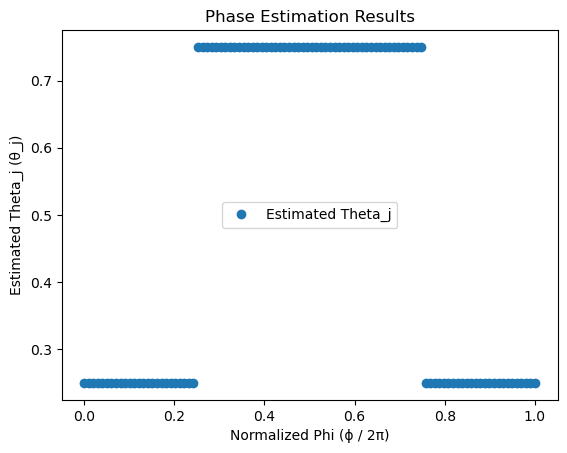

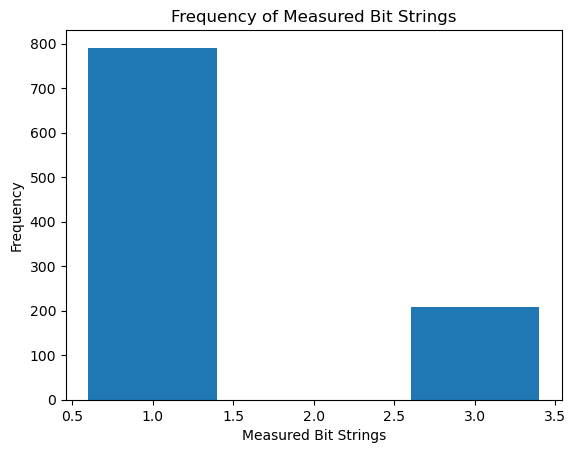

defaultdict(<class 'int'>, {(0.18919501586466764, '11'): 209, (0.8108049841353318, '01'): 791})


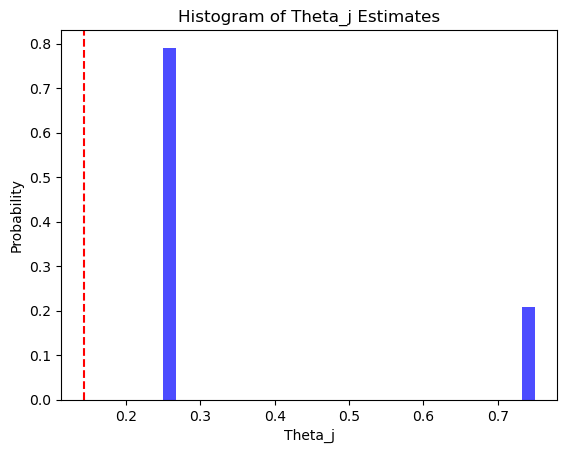

In [13]:
'''
	Build the 2 wire circuit, run the circuit for various phi values from 0 -> 2pi.
'''

circuit_template = """INITSTATE BASIS |01>
H 0
CPHASE 0 1 {phi}
H 0
MEASURE
"""

def write_circuit_file(phi, file_path):
	circuit_configuration = circuit_template.format(phi=phi)
	if os.path.exists(file_path):
		os.remove(file_path)
	with open(file_path, 'w') as file:
		file.write(circuit_configuration)
	outputFilePath = generateSimplifiedCircuit('./PhaseEstimation/circuit_template.circuit', './PhaseEstimation/simplifiedCir.circuit')
	return outputFilePath
	
# Get the 100 evenly space phi values here
phi_values = np.linspace(0, 2 * np.pi, 100)
phiVals = phi_values.tolist()
theta_j_estimates = defaultdict(float)

for phi in phiVals:
	outputFilePath = write_circuit_file(phi, './PhaseEstimation/circuit_template.circuit')
	numberOfWires, myInput=ReadInputString(open(outputFilePath).read())
	measured_tuple = SimulatorS(numberOfWires, myInput, False)
	_, bitString = measured_tuple
	theta_j = int(bitString, 2) / 2**(len(bitString))
	theta_j_estimates[phi] = theta_j
    
phiOver2Vals = []
for phi in phiVals:
    phiOver2Vals.append(phi / (2 * np.pi))
theta_j_values = []
for phi in phiVals:
    theta_j_values.append(theta_j_estimates[phi])
plt.plot(phiOver2Vals, theta_j_values, 'o')
plt.xlabel('Normalized Phi (ϕ / 2π)')
plt.ylabel('Estimated Theta_j (θ_j)')
plt.title('Phase Estimation Results')
plt.legend(['Estimated Theta_j'], loc='center')
plt.show()

# GRADING 2nd GRAPH: For a specific theta generate histogram of theta_j
phi = 0.1432394487827058 * 2 * np.pi
theta_j_estimates2 = []
outputFilePath = write_circuit_file(phi, './PhaseEstimation/circuit_template.circuit')
numberOfWires, myInput = ReadInputString(open(outputFilePath).read())
max_measured_tuple, freqMap = SimulatorS(numberOfWires, myInput, True)
print(freqMap)
for myTuple, count in freqMap.items():
	for i in range(count):
		theta_j = int(myTuple[1], 2) / 2**(len(bitString))
		theta_j_estimates2.append(theta_j)

bin_counts, bin_edges = np.histogram(theta_j_estimates2, bins=30)
total_count = sum(bin_counts)
bin_probabilities = bin_counts / total_count
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers, bin_probabilities, width=np.diff(bin_edges), color='blue', alpha=0.7)
plt.axvline(x=0.1432394487827058, color='red', linestyle='--')
plt.xlabel('Theta_j')
plt.ylabel('Probability')
plt.title('Histogram of Theta_j Estimates')
plt.show()



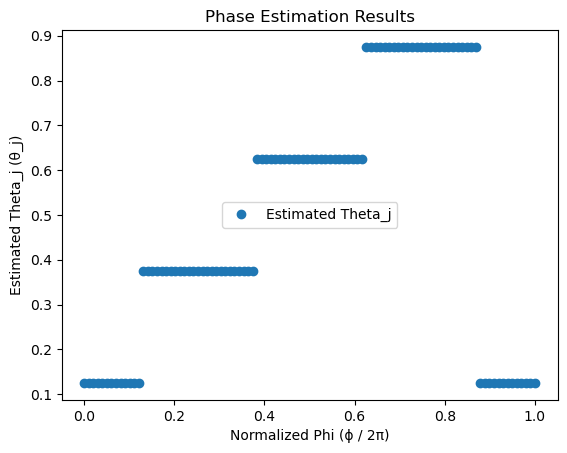

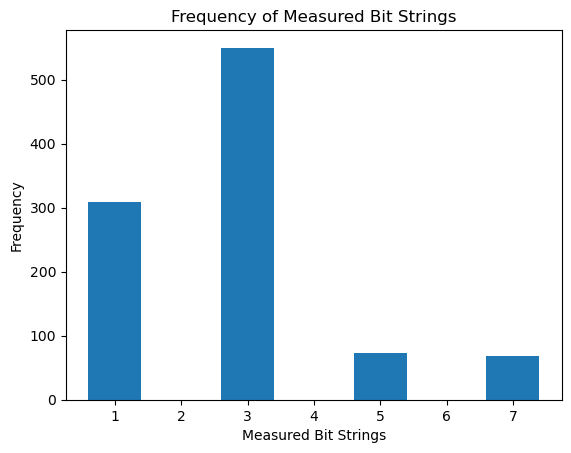

defaultdict(<class 'int'>, {(0.0664754175912603, '111'): 68, (0.5471256297552826, '011'): 550, (0.3132941966760943, '001'): 309, (0.07310475597736157, '101'): 73})


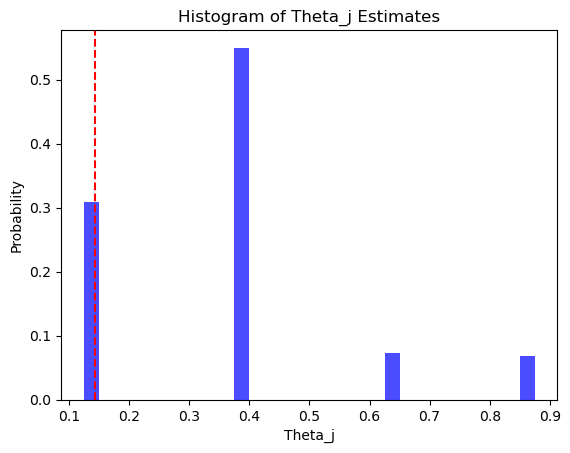

In [14]:
'''
	Build the 3 wire circuit, run the circuit for various phi values from 0 -> 2pi.
'''

circuit_template = """INITSTATE BASIS |001>
H 0
H 1
CPHASE 1 2 {phi}
CPHASE 0 2 {phi}
CPHASE 0 2 {phi}
H 0
CPHASE 0 1 -1.57079632679
H 1
SWAP 0 1
MEASURE
"""
def write_circuit_file(phi, file_path):
	circuit_configuration = circuit_template.format(phi=phi)
	if os.path.exists(file_path):
		os.remove(file_path)
	with open(file_path, 'w') as file:
		file.write(circuit_configuration)
	outputFilePath = generateSimplifiedCircuit('./PhaseEstimation/circuit_template.circuit', './PhaseEstimation/simplifiedCir.circuit')
	return outputFilePath
	
# Get the 100 evenly space phi values here
phi_values = np.linspace(0, 2 * np.pi, 100)
phiVals = phi_values.tolist()
theta_j_estimates = defaultdict(float)

for phi in phiVals:
	outputFilePath = write_circuit_file(phi, './PhaseEstimation/circuit_template.circuit')
	numberOfWires, myInput=ReadInputString(open(outputFilePath).read())
	measured_tuple = SimulatorS(numberOfWires, myInput, False)
	_, bitString = measured_tuple
	theta_j = int(bitString, 2) / 2**(len(bitString))
	theta_j_estimates[phi] = theta_j
    
phiOver2Vals = []
for phi in phiVals:
    phiOver2Vals.append(phi / (2 * np.pi))
theta_j_values = []
for phi in phiVals:
    theta_j_values.append(theta_j_estimates[phi])
plt.plot(phiOver2Vals, theta_j_values, 'o')
plt.xlabel('Normalized Phi (ϕ / 2π)')
plt.ylabel('Estimated Theta_j (θ_j)')
plt.title('Phase Estimation Results')
plt.legend(['Estimated Theta_j'], loc='center')
plt.show()

# GRADING 2nd GRAPH: For a specific theta generate histogram of theta_j
phi = 0.1432394487827058 * 2 * np.pi
theta_j_estimates2 = []
outputFilePath = write_circuit_file(phi, './PhaseEstimation/circuit_template.circuit')
numberOfWires, myInput = ReadInputString(open(outputFilePath).read())
max_measured_tuple, freqMap = SimulatorS(numberOfWires, myInput, True)
print(freqMap)
for myTuple, count in freqMap.items():
	for i in range(count):
		theta_j = int(myTuple[1], 2) / 2**(len(bitString))
		theta_j_estimates2.append(theta_j)

bin_counts, bin_edges = np.histogram(theta_j_estimates2, bins=30)
total_count = sum(bin_counts)
bin_probabilities = bin_counts / total_count
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers, bin_probabilities, width=np.diff(bin_edges), color='blue', alpha=0.7)
plt.axvline(x=0.1432394487827058, color='red', linestyle='--')
plt.xlabel('Theta_j')
plt.ylabel('Probability')
plt.title('Histogram of Theta_j Estimates')
plt.show()